In [ ]:
import torch
from transformers import pipeline as model
from PIL import Image
import matplotlib.pyplot as plt
import shap
import numpy as np

c:\Users\TheKi\OneDrive - UVG\Semestre X\Responsible AI\MobileNetV2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model

In [2]:
pipeline = model(
    task="image-classification",
    model="google/mobilenet_v2_1.4_224",
    dtype=torch.float16,
    device=0
)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 988.76it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [3]:
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

[{'label': 'lynx, catamount', 'score': 0.49208787083625793},
 {'label': 'tiger cat', 'score': 0.053095635026693344},
 {'label': 'tiger, Panthera tigris', 'score': 0.022047264501452446},
 {'label': 'wombat', 'score': 0.019532792270183563},
 {'label': 'tabby, tabby cat', 'score': 0.01871127262711525}]

## Choose the images

In [4]:
images_path = "data/"

In [5]:
images = [Image.open(images_path + "img_{}.jpg".format(i)) for i in range(1, 4)]

## Make predictions

In [6]:
predictions = pipeline(images, top_k=5)


Resultados para img_1.jpg:


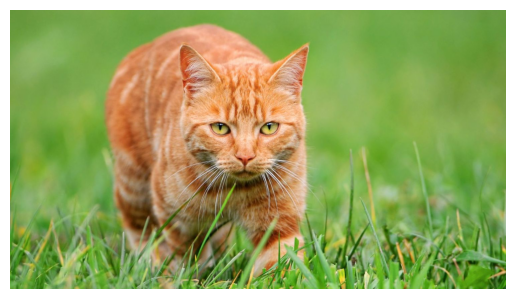

  tiger cat: 0.7237
  tabby, tabby cat: 0.1511
  Egyptian cat: 0.0146
  Persian cat: 0.0025
  ping-pong ball: 0.0014

----------------------------------------------------------------------

Resultados para img_2.jpg:


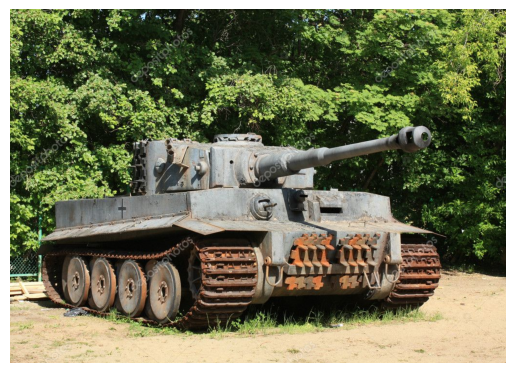

  tank, army tank, armored combat vehicle, armoured combat vehicle: 0.8034
  cannon: 0.0196
  amphibian, amphibious vehicle: 0.0071
  half track: 0.0063
  mortar: 0.0043

----------------------------------------------------------------------

Resultados para img_3.jpg:


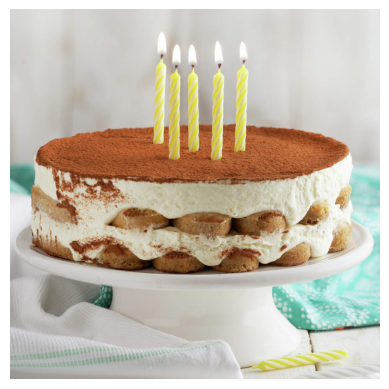

  candle, taper, wax light: 0.2022
  trifle: 0.1091
  potpie: 0.0451
  matchstick: 0.0383
  ice cream, icecream: 0.0383

----------------------------------------------------------------------


In [7]:
for i, preds in enumerate(predictions, 1):
    print(f"\nResultados para img_{i}.jpg:")
    plt.imshow(images[i-1])
    plt.axis('off')
    plt.show()
    for p in preds:
        print(f"  {p['label']}: {p['score']:.4f}")
    print("\n" + "-"*70)

## SHAP Explainer


============ SHAP para img_1.jpg ============


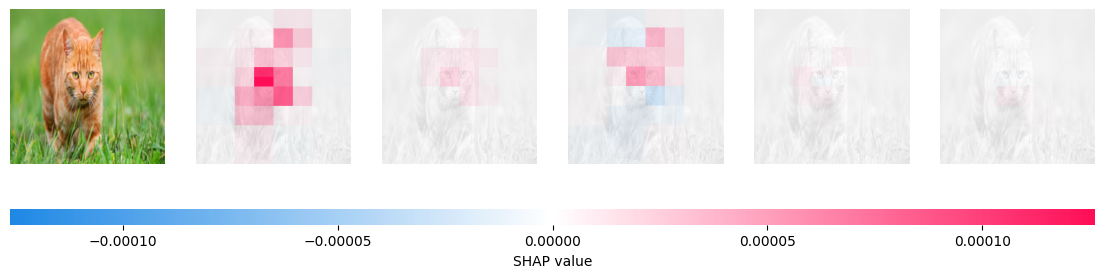

Top-5 clases explicadas:
  tiger cat: 0.5146
  tabby, tabby cat: 0.0909
  Egyptian cat: 0.0844
  lynx, catamount: 0.0247
  Persian cat: 0.0056

============ SHAP para img_2.jpg ============


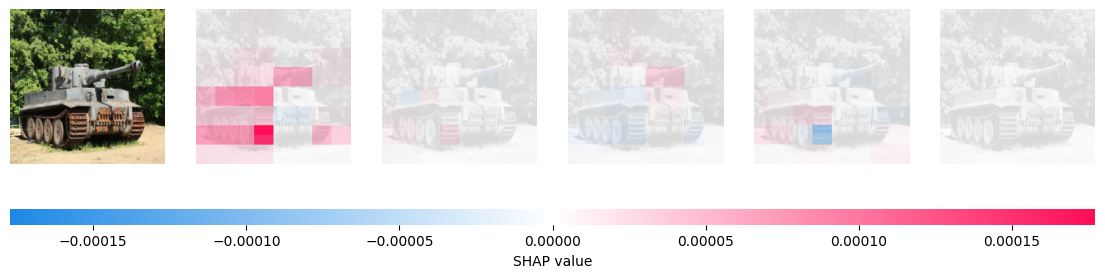

Top-5 clases explicadas:
  tank, army tank, armored combat vehicle, armoured combat vehicle: 0.9302
  half track: 0.0052
  cannon: 0.0039
  amphibian, amphibious vehicle: 0.0032
  harvester, reaper: 0.0009

============ SHAP para img_3.jpg ============


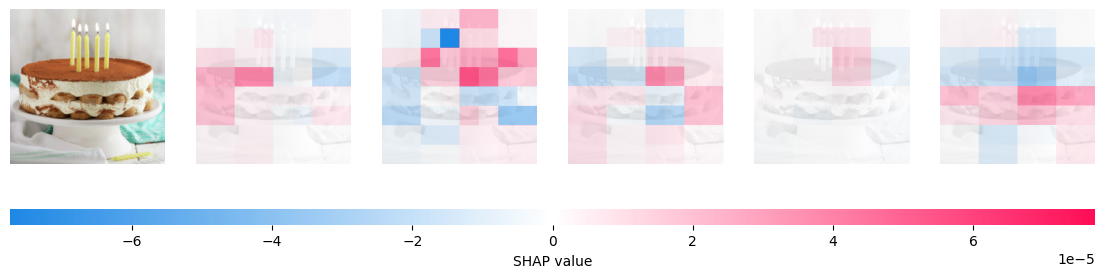

Top-5 clases explicadas:
  trifle: 0.1658
  candle, taper, wax light: 0.1423
  potpie: 0.0887
  matchstick: 0.0329
  eggnog: 0.0196


In [ ]:
# --- 1) setup: modelo, processor, clases en orden estable ---
hf_model = pipeline.model
device_torch = hf_model.device
processor = getattr(pipeline, "image_processor", None) or getattr(pipeline, "feature_extractor", None)
id2label = hf_model.config.id2label
CLASS_ORDER = [id2label[i] for i in sorted(id2label.keys())]
_label_to_idx = {lbl: i for i, lbl in enumerate(CLASS_ORDER)}
N_CLASSES = len(CLASS_ORDER)

# tamaño de entrada del modelo (MobileNet v2: 224x224)
H = processor.size.get("height", 224)
W = processor.size.get("width", 224)

def _to_pil_rgb(x):
    if isinstance(x, Image.Image):
        return x.convert("RGB")
    arr = np.array(x)
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    return Image.fromarray(arr.astype(np.uint8)).convert("RGB")

def _prepare_img_for_shap(pil_img):
    # reducimos a 224x224 para que el masker no cree millones de features
    return np.array(_to_pil_rgb(pil_img).resize((W, H), Image.BILINEAR))

@torch.no_grad()
def hf_predict_proba(batch_hwc):
    """
    batch_hwc: (N,H,W,3) np.array o lista de PIL/arrays
    -> (N, N_CLASSES) probabilidades en orden CLASS_ORDER
    """
    if isinstance(batch_hwc, np.ndarray) and batch_hwc.ndim == 3:
        batch = [_to_pil_rgb(batch_hwc)]
    elif isinstance(batch_hwc, np.ndarray) and batch_hwc.ndim == 4:
        batch = [_to_pil_rgb(img) for img in batch_hwc]
    elif isinstance(batch_hwc, list):
        batch = [_to_pil_rgb(img) for img in batch_hwc]
    else:
        batch = [_to_pil_rgb(batch_hwc)]

    inputs = processor(images=batch, return_tensors="pt")
    model_dtype = next(hf_model.parameters()).dtype
    inputs = {k: v.to(device_torch) for k, v in inputs.items()}
    if inputs["pixel_values"].dtype != model_dtype:
        inputs["pixel_values"] = inputs["pixel_values"].to(model_dtype)

    logits = hf_model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy().astype(np.float32)
    return probs

# --- 2) masker + explainer (partition) con imagen 224x224 ---
img0_small = _prepare_img_for_shap(images[0])
masker = shap.maskers.Image("blur(20,20)", img0_small.shape)
explainer = shap.Explainer(hf_predict_proba, masker, algorithm="partition")

# --- 3) explicación Top-K por imagen, con límites de cómputo ---
def shap_topk_for_image(pil_image, top_k=5, width=14, max_evals=300, batch_size=50):
    img_small = _prepare_img_for_shap(pil_image)                 # (224,224,3)
    probs = hf_predict_proba(np.array([img_small]))[0]
    topk_idx = probs.argsort()[::-1][:top_k]

    # limitar salidas y evaluaciones para evitar explosión de memoria
    sv = explainer(
        np.array([img_small]),
        outputs=topk_idx,          # sólo explicamos Top-K clases
        max_evals=max_evals,       # reduce número de evaluaciones
        batch_size=batch_size,     # evalúa en lotes
        silent=True
    )

    vals = sv.values              # (1,H,W,C,K_top) o (1,H,W,K_top)
    if vals.ndim == 4:            # (1,H,W,K_top) -> añadir canal ficticio
        vals = vals[..., None, :]

    # ‘outs’ ya corresponde a K_top salidas en el último eje
    outs = [vals[..., k] for k in range(vals.shape[-1])]
    shap.image_plot(outs, pixel_values=np.array([img_small]), width=width)

    print("Top-{} clases explicadas:".format(top_k))
    for k in topk_idx:
        print(f"  {CLASS_ORDER[k]}: {probs[k]:.4f}")

# --- 4) correr sobre tus imágenes ---
for i, im in enumerate(images, 1):
    print("\n" + "="*12 + f" SHAP para img_{i}.jpg " + "="*12)
    shap_topk_for_image(im, top_k=5, width=14, max_evals=300, batch_size=50)
